In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from pprint import pprint
from datetime import datetime

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import PartialDependenceDisplay

# Estimated Construction Costs for Housing

In [2]:
dbi = gpd.read_feather('../data/dbi_permits.geofeather')

In [3]:
homes = pd.read_excel('../data/Housing Production 2005-2022.xlsx')

In [4]:
costs = dbi[dbi.estimated_cost.notna() | dbi.revised_cost.notna()]
costs = costs.copy()

In [5]:
costs['cost'] = costs.revised_cost
costs['cost'] = costs['cost'].fillna(costs.estimated_cost)

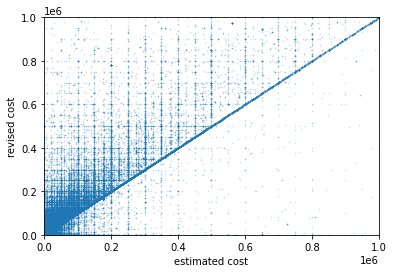

In [6]:
plt.scatter(dbi.estimated_cost, dbi.revised_cost, alpha=.25, s=.25)
plt.xlim((0, 1000000))
plt.ylim((0, 1000000))
plt.ylabel('revised cost')
plt.xlabel('estimated cost')
plt.show()

In [7]:
costs['new_units'] = costs['proposed_units'].fillna(0) - costs['existing_units'].fillna(0)

In [8]:
costs = costs.sort_values(['new_units'], ascending=False)

In [9]:
housing_costs = costs[costs.permit_number.isin(homes.BPA)]

In [10]:
housing_costs = housing_costs[housing_costs['completed_date'].notna()
                              & (housing_costs['new_units'] > 0)
                              & housing_costs['permit_type'].isin(('3','2','1'))]

In [11]:
housing_costs = housing_costs[housing_costs.permit_creation_date.dt.year > 2006]

In [12]:
housing_costs = housing_costs.sort_values('cost')

## Geospatial bluesky data

In [13]:
bluesky = gpd.read_feather('../geobluesky.geofeather')

In [14]:
bluesky = bluesky[bluesky['year'] >= 2007]

In [15]:
bluesky.year.max()

2016.0

In [16]:
bluesky.shape

(1530894, 19)

In [17]:
bluesky.crs

<Geographic 2D CRS: {"$schema": "https://proj.org/schemas/v0.6/projjso ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

## Tax Data

In [18]:
tax = gpd.read_feather('../data/tax.geofeather')

In [19]:
tax = tax.to_crs(bluesky.crs)

In [20]:
tax.closed_roll_year.min()

2007

In [21]:
df_list = []

for year in range(2007, 2017):
    parcels_year = bluesky[bluesky.year == year].copy()
    tax_year = tax[tax.closed_roll_year == year].copy()
    df_list.append(gpd.sjoin(parcels_year, tax_year, how='left', predicate='contains'))
    
    

In [22]:
panel_data = pd.concat(df_list)

In [23]:
panel_data.shape

(1911851, 59)

I first do a geospatial match, but when a one to many relationship is identified, i give priority to non-geospatial matching

In [24]:
panel_data['non_geo_match'] = panel_data['MapBlkLot_Master'] == (panel_data.block + panel_data.lot)

panel_data = panel_data.sort_values('non_geo_match', ascending=False)

In [25]:
panel_data = panel_data.drop_duplicates(['MapBlkLot_Master', 'year'])

In [26]:
panel_data.shape

(1530894, 60)

In [27]:
panel_data = panel_data.drop(columns='index_right')

### Now to estimate housing costs given parcel and tax data

In [28]:
housing_costs = housing_costs[(housing_costs.cost / housing_costs.new_units) > 5000]

In [29]:
housing_costs_grouped = housing_costs.groupby(
    [
        'geometry', 
        'permit_creation_date'
    ]).agg({'cost': 'sum', 'new_units': 'sum'}).reset_index()

In [30]:
(housing_costs_grouped.cost / housing_costs_grouped.new_units).quantile(
    [0.01, 0.05, .1, .2, .3, .4, .5, .6, .7, .8, .9]
)

0.01     10000.000000
0.05     20000.000000
0.10     35000.000000
0.20     60000.000000
0.30     83333.333333
0.40    113841.509434
0.50    172052.961538
0.60    276245.210728
0.70    351250.000000
0.80    437902.400000
0.90    560152.000000
dtype: float64

In [31]:
housing_costs = gpd.GeoDataFrame(housing_costs_grouped, crs=dbi.crs)

In [32]:
panel_data = panel_data.to_crs(housing_costs.crs)

## Specify year

In [33]:
df_list = []

for year in range(2007, 2017):
    parcels_year = panel_data[panel_data.year == year].copy()
    housing_costs_year = housing_costs[housing_costs.permit_creation_date.dt.year == year].copy()
    df_list.append(gpd.sjoin(parcels_year, housing_costs_year, how='left', predicate='contains'))

In [34]:
panel_costs_df = pd.concat(df_list)

In [35]:
panel_costs_df.cost.notna().sum()

1609

In [36]:
panel_costs_df = panel_costs_df.drop(columns= ['MapBlkLot_Master', 'mapblklot', 'geometry',
                     'index_right', 'closed_roll_year', 'lot', 'block',
                     'current_sales_date', 'property_location', 
                     'parcel_number', 'non_geo_match', 'permit_creation_date'])

In [37]:
y = panel_costs_df['cost']

In [38]:
panel_costs_df.columns

Index(['year', 'Developed', 'Historic', 'Residential_Dummy',
       'Zillow_Price_Real', 'Const_FedReserve_Real', 'Envelope_1000',
       'Upzone_Ratio', 'zp_OfficeComm', 'zp_DensRestMulti',
       'zp_FormBasedMulti', 'zp_PDRInd', 'zp_Public', 'zp_Redev', 'zp_RH2',
       'zp_RH3_RM1', 'property_class_code_definition', 'lot_code',
       'property_area', 'volume_number', 'percent_of_ownership',
       'misc_exemption_value', 'zoning_code', 'year_property_built',
       'analysis_neighborhood', 'number_of_units', 'use_definition',
       'status_code', 'number_of_bedrooms', 'assessor_neighborhood',
       'number_of_stories', 'assessor_neighborhood_district',
       'exemption_code_definition', 'lot_area', 'number_of_rooms', 'lot_depth',
       'assessed_personal_property_value', 'supervisor_district_2012',
       'number_of_bathrooms', 'construction_type', 'lot_frontage',
       'homeowner_exemption_value', 'tax_rate_area_code',
       'assessed_fixtures_value', 'supervisor_district',

In [39]:
panel_costs_df['supervisor_district'] = panel_costs_df['supervisor_district'].astype('category')

In [40]:
X = panel_costs_df.drop(columns=['cost', 'Zillow_Price_Real', 'Const_FedReserve_Real'])

In [41]:
X = pd.get_dummies(X, drop_first=True, dummy_na=True)

In [42]:
for c in X.columns[:35]:
    X['new_units_' + str(c)] = X['new_units'] * X[c]

In [43]:
X = X.fillna(-9999)

In [44]:
X.shape

(1530918, 541)

In [45]:
trainX, testX, trainY = X.loc[y.notna()], X.loc[y.isna()], y[y.notna()]

In [46]:
trainY.shape

(1609,)

In [47]:
regression = Pipeline([('rf',
                        ExtraTreesRegressor(n_estimators=500, random_state=0, 
                                            max_samples=1000, n_jobs=-1, bootstrap=True))])
rf_param_grid = [
    {
        'rf__max_depth': stats.randint(5, 35),
        'rf__ccp_alpha': stats.loguniform(1e-14, 1e-7),
        'rf__max_features': stats.uniform(.98, .02),
        'rf__max_samples': stats.randint(900, int(trainY.shape[0]*.8))
    }
]

In [49]:
rs = RandomizedSearchCV(regression, rf_param_grid, n_iter=50, random_state=0, verbose=1, cv=5)

rs.fit(trainX, trainY)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('rf',
                                              ExtraTreesRegressor(bootstrap=True,
                                                                  max_samples=1000,
                                                                  n_estimators=500,
                                                                  n_jobs=-1,
                                                                  random_state=0))]),
                   n_iter=50,
                   param_distributions=[{'rf__ccp_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002E10B9CCC40>,
                                         'rf__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002E1083F39D0>,
                                         'rf__max_features': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002E10B9D1A00>,
                                         'rf__max_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002E10B9D5CD0>}],
                   random_state=0, verbose=1)

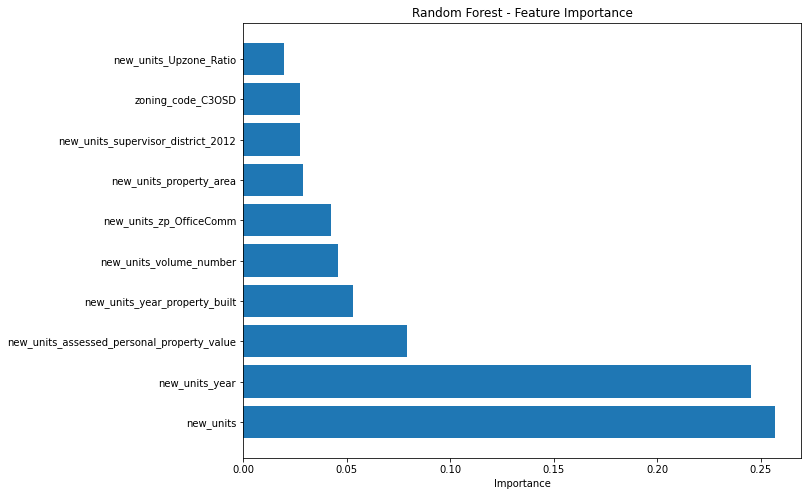

In [50]:
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df[:10]

    plt.figure(figsize=(10,8))
    plt.barh(fi_df['feature_names'], fi_df['feature_importance'], align='center')
    plt.xlabel('Importance')
    plt.title(model_type + ' - Feature Importance')
    plt.show()

plot_feature_importance(rs.best_estimator_['rf'].feature_importances_, X.columns, 'Random Forest')

In [51]:
param_search_results = pd.DataFrame(rs.cv_results_['params'])
param_search_results['score'] = rs.cv_results_['mean_test_score']
param_search_results = param_search_results.sort_values('score', ascending=False)

In [52]:
param_search_results

,rf__ccp_alpha,rf__max_depth,rf__max_features,rf__max_samples,score
1,6.519020e-11,14,0.992471,1142,0.744613
18,5.929816e-13,20,0.989494,1179,0.742979
3,2.206256e-11,12,0.990578,988,0.742907
49,7.357663e-14,24,0.997299,929,0.742328
5,3.445110e-10,21,0.996652,1235,0.742165
19,2.323022e-12,26,0.993127,1205,0.742105
6,1.230510e-08,23,0.989472,1077,0.741798
41,2.118888e-10,23,0.997569,1107,0.741610
4,5.616860e-12,30,0.981421,1165,0.741525
47,9.992844e-10,16,0.996823,1056,0.741472


In [53]:
testY = rs.predict(testX)

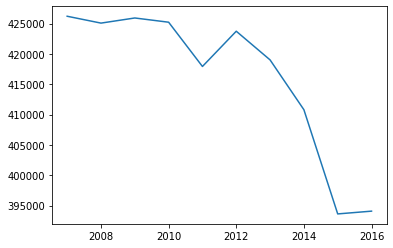

In [54]:
plt.plot(pd.DataFrame({'year': testX['year'], 'cost': testY}).groupby('year').agg({'cost': 'mean'}))

In [96]:
trainY.min()

6000.0

(-150000.0, 50000.0)

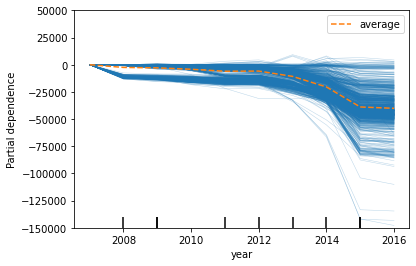

In [113]:
PartialDependenceDisplay.from_estimator(
    rs, 
    X.sample(5000, random_state=0), 
    ['year'], 
    kind='both', centered=True)
plt.ylim(-150000, 50000)


In [56]:
known_construction = pd.read_csv('../data/efz/construction.csv', skiprows=1, sep=' ', on_bad_lines='skip')

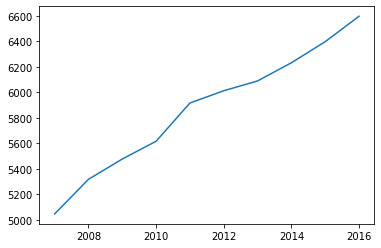

In [57]:
plt.plot(known_construction[(known_construction['YEAR'] > 2006) & 
                            (known_construction['YEAR'] < 2017)].groupby('YEAR')['BCI'].mean())

In [119]:
panel_data['construction_cost_est'] = 0

In [120]:
panel_data.loc[X.loc[y.isna()].index, 'construction_cost_est'] = testY

In [121]:
panel_data.loc[X.loc[y.notna()].index, 'construction_cost_est'] = trainY

In [122]:
panel_data.to_feather('../data/panel_data_estimated_costs.geofeather')

In [ ]:
param_search_results